In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import geopandas as gpd
from shapely.geometry import Point

import folium
from folium.plugins import HeatMap

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer


import warnings
warnings.filterwarnings("ignore")

## **This notebook analyzes the following variables: VRI, Geography, Customers, Number of trees**
## 1. Preprocess the datasets

In [2]:
vri_df = pd.read_csv('src_vri_snapshot_2024_03_20.csv')
span_df = pd.read_csv('dev_wings_agg_span_2024_01_01.csv')
gis_2024_1004 = pd.read_csv('gis_weatherstation_shape_2024_10_04.csv')
station_summary_2023_08_02 = pd.read_csv('src_wings_meteorology_station_summary_snapshot_2023_08_02.csv')
windspeed_2023_08_02 = pd.read_csv('src_wings_meteorology_windspeed_snapshot_2023_08_02.csv')

In [3]:
merged_df = pd.merge(station_summary_2023_08_02, gis_2024_1004, right_on= 'weatherstationcode', left_on='station', how='left')
merged_df.head()

,station,vri,alert,max_gust,99th,95th,snapshot_date_x,objectid,weatherstationcode,weatherstationname,...,elevation,twinguid,hftd,zone1idc,hftdidc,gdb_geomattr_data,globalid,shape,shape_srid,snapshot_date_y
0,AMO,H,35,40,32,24,2023-08-02,8.0,AMO,Ammo Dump,...,542.0,NaN,2.0,N,Y,NaN,{90874863-3E3A-4D88-A597-C531DBEE6E90},POINT (1556019.1347 12109260.1389),4431.0,10/4/2024
1,ANE,M,35,43,32,25,2023-08-02,89.0,ANE,Alpine,...,1814.0,NaN,2.0,N,Y,NaN,{53D5C3DA-4940-462A-AC06-26A36FC68783},POINT (1710032.1223 11916452.7548),4431.0,10/4/2024
2,ARH,L,40,46,40,31,2023-08-02,9.0,ARH,Archie Moore,...,1509.0,NaN,3.0,N,Y,NaN,{49DC14E1-2AE9-4575-93A8-C31AABF2AF48},POINT (1652898.10565 11993905.15735),4431.0,10/4/2024
3,AVO,H,35,43,29,24,2023-08-02,175.0,AVO,Avocado,...,658.0,NaN,2.0,N,Y,NaN,{35312FA1-D8E4-4D96-B61C-AEE1121077B5},POINT (1562731.0996 12122126.3274),4431.0,10/4/2024
4,AVY,L,45,62,53,40,2023-08-02,92.0,AVY,Anderson Valley,...,2667.0,NaN,3.0,N,Y,NaN,{CA560362-E0CE-495F-95A7-FE78A1AC3EBC},POINT (1717786.26886 11930149.546),4431.0,10/4/2024


In [4]:
windspeed_grouped_count = windspeed_2023_08_02.groupby(by='station').count()
windspeed_grouped_count.head()

,date,wind_speed,snapshot_date
station,,,
AMO,179,166,179
ANE,179,179,179
ARH,179,179,179
AVO,179,179,179
AVY,179,116,179


In [5]:
station_codes = np.array(gis_2024_1004['weatherstationcode'])
merged_station_df = gis_2024_1004.merge(station_summary_2023_08_02, left_on='weatherstationcode', right_on='station', how='left')


In [6]:
merged_df[merged_df['weatherstationcode']=='AMO']['alert'].iloc[0]

prob_lst = []

for station in station_codes:
    station_windspeeds = np.array(windspeed_2023_08_02[windspeed_2023_08_02['station'] == station]['wind_speed'])
    # "alert" might be nan because of less entries in station_ss_df
    has_threshold = True
    try:
        threshold = merged_df[merged_df['weatherstationcode'] == station]['alert'].iloc[0]
    except:
        has_threshold = False
        prob = np.nan
    mean = np.nanmean(station_windspeeds)
    if has_threshold:
        prob = np.mean([1 if x >= threshold else 0 for x in station_windspeeds]) * 100
    count = np.count_nonzero(~np.isnan(station_windspeeds))
    prob_lst.append([station, station_windspeeds, threshold, count, mean, prob])

In [7]:
prob_df = pd.DataFrame(prob_lst)
prob_df.columns = ['station', 'windspeeds', 'threshold', 'count', 'mean', 'probability (%)']
prob_df.head()

,station,windspeeds,threshold,count,mean,probability (%)
0,CBD,"[nan, nan, nan, nan, nan, nan, nan, nan, 11.0,...",35,171,16.251462,1.117318
1,CCR,"[31.0, 26.0, 27.0, 35.0, 24.0, 24.0, 25.0, 23....",45,179,31.413408,13.966480
2,CES,"[33.0, 25.0, 26.0, 38.0, 26.0, 24.0, 23.0, 19....",41,173,28.294798,7.262570
3,ROV,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",45,49,24.265306,2.793296
4,CHO,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",35,117,14.213675,0.000000


In [8]:
gis_2024_1004['shape'] = gpd.GeoSeries.from_wkt(gis_2024_1004['shape'])
gis_gdf = gpd.GeoDataFrame(gis_2024_1004, geometry='shape').set_crs(epsg=4431).to_crs(epsg=4326)

vri_df['shape'] = gpd.GeoSeries.from_wkt(vri_df['shape'])
vri_gdf = gpd.GeoDataFrame(vri_df, geometry='shape').set_crs(epsg=4326)

span_df['shape'] = gpd.GeoSeries.from_wkt(span_df['shape'])
span_gdf = gpd.GeoDataFrame(span_df, geometry='shape').set_crs(epsg=2230).to_crs(epsg=4326)

In [9]:
gis_gdf = gis_gdf.drop(columns=['shape_srid'])
vri_gdf = vri_gdf.drop(columns=['shape_srid'])
span_gdf = span_gdf.drop(columns=['shape_srid'])


In [10]:
gis_vri_merge = gis_gdf.merge(vri_gdf, left_on='weatherstationcode', right_on='anemometercode')
vri_gdf['centroid'] = vri_gdf['shape'].centroid
vri_gis_sjoin = vri_gdf.sjoin(gis_gdf, how='inner')

In [11]:
prob_merge = vri_gis_sjoin.merge(prob_df, left_on='weatherstationcode', right_on='station').merge(station_summary_2023_08_02, left_on='weatherstationcode', right_on='station')
prob_merge

,name,tessellate,extrude,visibility,globalid_left,anemometer,anemometercode,circuit,district_left,secdevice,...,count,mean,probability (%),station_y,vri,alert,max_gust,99th,95th,snapshot_date
0,Alpine_VRI,-1,0,-1,{9301dece-bb90-40f2-a2b3-97ddb7e2da50},Alpine_VRI,ANE,NaN,EA,NaN,...,179,19.044693,2.234637,ANE,M,35,43,32,25,2023-08-02
1,Ammo Dump_VRI,-1,0,-1,{c0955e19-d2f7-49f5-80ce-d0c46bc76e79},Ammo Dump_VRI,AMO,NaN,NC,NaN,...,166,19.096386,0.558659,AMO,H,35,40,32,24,2023-08-02
2,Anderson Valley_VRI,-1,0,-1,{8fd4f643-514c-4b53-ad51-a9ac54abcbb3},Anderson Valley_VRI,AVY,NaN,EA,NaN,...,116,33.853448,13.966480,AVY,L,45,62,53,40,2023-08-02
3,Archie Moore_VRI,-1,0,-1,{e2879aaa-fc7a-455e-af56-382a253d08f0},Archie Moore_VRI,ARH,NaN,NE,NaN,...,179,25.396648,6.703911,ARH,L,40,46,40,31,2023-08-02
4,Avocado_VRI,-1,0,-1,{ef385198-487b-483e-83c4-ee9496ac29d6},Avocado_VRI,AVO,NaN,NE,NaN,...,179,19.687151,2.234637,AVO,H,35,43,29,24,2023-08-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,TL23051_VRI,-1,0,-1,NaN,TL23051_VRI,NaN,NaN,NaN,NaN,...,115,18.017391,0.000000,RPQ,L,35,36,28,23,2023-08-02
302,TL23051_VRI,-1,0,-1,NaN,TL23051_VRI,NaN,NaN,NaN,NaN,...,61,24.852459,2.234637,BMR,L,45,56,53,39,2023-08-02
303,TL23053_VRI,-1,0,-1,NaN,TL23053_VRI,NaN,NaN,NaN,NaN,...,179,18.849162,1.117318,DMH,M,35,39,34,27,2023-08-02
304,TL50001_VRI,-1,0,-1,{36e69838-9e70-40d8-9bbe-21c5920f6187},TL50001_VRI,NaN,NaN,EA;CM,NaN,...,61,35.672131,6.145251,PCT,L,45,54,51,41,2023-08-02


In [12]:
vri_mapping = {'H': 2, 'M': 1, 'L': 0}
prob_merge['vri_numeric'] = prob_merge['vri'].map(vri_mapping)

In [13]:
prob_merge.head()

,name,tessellate,extrude,visibility,globalid_left,anemometer,anemometercode,circuit,district_left,secdevice,...,mean,probability (%),station_y,vri,alert,max_gust,99th,95th,snapshot_date,vri_numeric
0,Alpine_VRI,-1,0,-1,{9301dece-bb90-40f2-a2b3-97ddb7e2da50},Alpine_VRI,ANE,NaN,EA,NaN,...,19.044693,2.234637,ANE,M,35,43,32,25,2023-08-02,1.0
1,Ammo Dump_VRI,-1,0,-1,{c0955e19-d2f7-49f5-80ce-d0c46bc76e79},Ammo Dump_VRI,AMO,NaN,NC,NaN,...,19.096386,0.558659,AMO,H,35,40,32,24,2023-08-02,2.0
2,Anderson Valley_VRI,-1,0,-1,{8fd4f643-514c-4b53-ad51-a9ac54abcbb3},Anderson Valley_VRI,AVY,NaN,EA,NaN,...,33.853448,13.966480,AVY,L,45,62,53,40,2023-08-02,0.0
3,Archie Moore_VRI,-1,0,-1,{e2879aaa-fc7a-455e-af56-382a253d08f0},Archie Moore_VRI,ARH,NaN,NE,NaN,...,25.396648,6.703911,ARH,L,40,46,40,31,2023-08-02,0.0
4,Avocado_VRI,-1,0,-1,{ef385198-487b-483e-83c4-ee9496ac29d6},Avocado_VRI,AVO,NaN,NE,NaN,...,19.687151,2.234637,AVO,H,35,43,29,24,2023-08-02,2.0


In [14]:
span_df_cleaned = span_df.dropna(subset=['station'])
span_vri_prob_merge_df = prob_merge.merge(span_df_cleaned, left_on='anemometercode', right_on='station')
span_vri_prob_merge_df

,name,tessellate,extrude,visibility,globalid_left,anemometer,anemometercode,circuit,district_left,secdevice,...,exclusive_tree_ids,exclusive_tree_counts,transformer_counts,model_major_ver,model_minor_ver,model_patch_ver,snapshot_date_y,upstream_span_id,shape_y,shape_srid
0,Alpine_VRI,-1,0,-1,{9301dece-bb90-40f2-a2b3-97ddb7e2da50},Alpine_VRI,ANE,NaN,EA,NaN,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{9DD3F2A2-F7E7-4074-8E61-A8E64F99E953},"LINESTRING (6400148.702 1879679.62, 6400147.86...",2230
1,Alpine_VRI,-1,0,-1,{9301dece-bb90-40f2-a2b3-97ddb7e2da50},Alpine_VRI,ANE,NaN,EA,NaN,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{85B7A68E-E46F-48F5-A9A6-BF252F6AD5AA},"LINESTRING (6400753.809 1883222.725, 6400753.7...",2230
2,Alpine_VRI,-1,0,-1,{9301dece-bb90-40f2-a2b3-97ddb7e2da50},Alpine_VRI,ANE,NaN,EA,NaN,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{6FB14D84-8C41-424D-9607-F71AA18B216F},"LINESTRING (6399140.97 1878808.879, 6399137.3 ...",2230
3,Alpine_VRI,-1,0,-1,{9301dece-bb90-40f2-a2b3-97ddb7e2da50},Alpine_VRI,ANE,NaN,EA,NaN,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{A106B801-7D31-4041-9198-C662A8562D01},"LINESTRING (6400727.303 1883356.844, 6400726.5...",2230
4,Alpine_VRI,-1,0,-1,{9301dece-bb90-40f2-a2b3-97ddb7e2da50},Alpine_VRI,ANE,NaN,EA,NaN,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{F36E9570-4C09-4DE6-B737-52D829E21C89},"LINESTRING (6399850.214 1879672.333, 6399851.2...",2230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328640,TL6914_VRI,-1,0,-1,{27fb2747-06f6-4fca-830d-13f2f4a84290},TL6914_VRI,COC,NaN,EA,NaN,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{0B4ACEF9-DEEE-4538-99A9-61B68996CC0F},"LINESTRING (6365746.048 1888563.753, 6365747.6...",2230
328641,TL6914_VRI,-1,0,-1,{27fb2747-06f6-4fca-830d-13f2f4a84290},TL6914_VRI,COC,NaN,EA,NaN,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{6B1555CE-B4F2-4D50-B22E-7EFEAB3D31B4},"LINESTRING (6368249.692 1889045.129, 6368246.2...",2230
328642,TL6914_VRI,-1,0,-1,{27fb2747-06f6-4fca-830d-13f2f4a84290},TL6914_VRI,COC,NaN,EA,NaN,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{CCCD90FF-CA66-4B37-BC15-91A84BA99063},"LINESTRING (6368194.329 1890451.523, 6368194.2...",2230
328643,TL6914_VRI,-1,0,-1,{27fb2747-06f6-4fca-830d-13f2f4a84290},TL6914_VRI,COC,NaN,EA,NaN,...,NaN,NaN,NaN,3.0,158.0,0.0,2024-01-01,{04C414DC-9BD0-4BF4-ABE1-3AC97AF43142},"LINESTRING (6367571.813 1889558.469, 6367570.5...",2230


In [15]:
print(list(span_vri_prob_merge_df.columns))

['name', 'tessellate', 'extrude', 'visibility', 'globalid_left', 'anemometer', 'anemometercode', 'circuit', 'district_left', 'secdevice', 'structureid_left', 'tlid', 'gust_99pct', 'gust_95pct', 'gust_max', 'vri_risk', 'loaddate', 'county', 'hftd_left', 'hftdidc_left', 'zone1idc_left', 'globalid_1', 'shape_length', 'shape_area', 'shape_x', 'snapshot_date_left', 'centroid', 'index_right', 'objectid', 'weatherstationcode', 'weatherstationname', 'scadartuid', 'structureid_right', 'nwszone', 'district_right', 'thomasbrospagegrid', 'constructionstatus', 'creationuser', 'datecreated', 'datemodified', 'lastuser', 'structureguid', 'symbolrotation', 'latitude', 'longitude', 'elevation', 'twinguid', 'hftd_right', 'zone1idc_right', 'hftdidc_right', 'gdb_geomattr_data', 'globalid_right', 'snapshot_date_right', 'station_x', 'windspeeds', 'threshold', 'count', 'mean', 'probability (%)', 'station_y', 'vri_x', 'alert', 'max_gust', '99th', '95th', 'snapshot_date_x', 'vri_numeric', 'Unnamed: 0', 'globali

In [16]:
columns_to_keep = [
    'probability (%)',
    'vri_numeric', 'elevation', 'longitude', 'latitude',
    'cust_total', 'cust_lifesupport', 'cust_urgent', 'cust_medicalcert', 'cust_essential',
    'cust_sensitive', 'cust_residential', 'cust_commercial', 'cust_industrial',
    'num_strike_trees', 'buffered_tree_counts', 'exclusive_tree_counts'
]

df_filtered = span_vri_prob_merge_df[columns_to_keep]

columns_to_impute = ['num_strike_trees', 'buffered_tree_counts', 'exclusive_tree_counts']
for col in columns_to_impute:
    min_val, max_val = df_filtered[col].min(), df_filtered[col].max()
    df_filtered[col] = df_filtered[col].apply(
        lambda x: np.random.randint(min_val, max_val + 1) if pd.isna(x) else x
    )

df_filtered.shape

(328645, 17)

In [17]:
df_filtered

,probability (%),vri_numeric,elevation,longitude,latitude,cust_total,cust_lifesupport,cust_urgent,cust_medicalcert,cust_essential,cust_sensitive,cust_residential,cust_commercial,cust_industrial,num_strike_trees,buffered_tree_counts,exclusive_tree_counts
0,2.234637,1.0,1814,-116.773356,32.827078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,381.0,69.0
1,2.234637,1.0,1814,-116.773356,32.827078,23.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,8.0,257.0
2,2.234637,1.0,1814,-116.773356,32.827078,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,358.0,265.0
3,2.234637,1.0,1814,-116.773356,32.827078,31.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,317.0,118.0
4,2.234637,1.0,1814,-116.773356,32.827078,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,98.0,208.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328640,2.234637,0.0,761,-116.895280,32.851450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,99.0
328641,2.234637,0.0,761,-116.895280,32.851450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,283.0,268.0
328642,2.234637,0.0,761,-116.895280,32.851450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,326.0
328643,2.234637,0.0,761,-116.895280,32.851450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,297.0,141.0


## 2. EDA

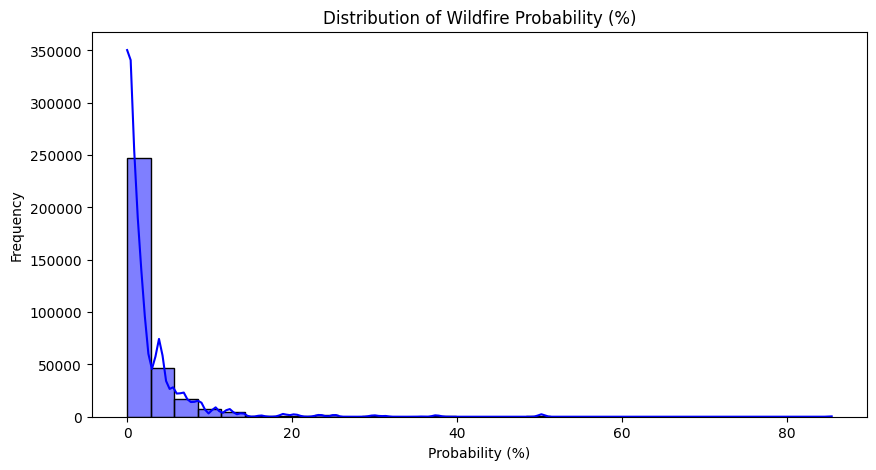

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(df_filtered['probability (%)'], bins=30, kde=True, color='blue')
plt.title("Distribution of Wildfire Probability (%)")
plt.xlabel("Probability (%)")
plt.ylabel("Frequency")
plt.show()


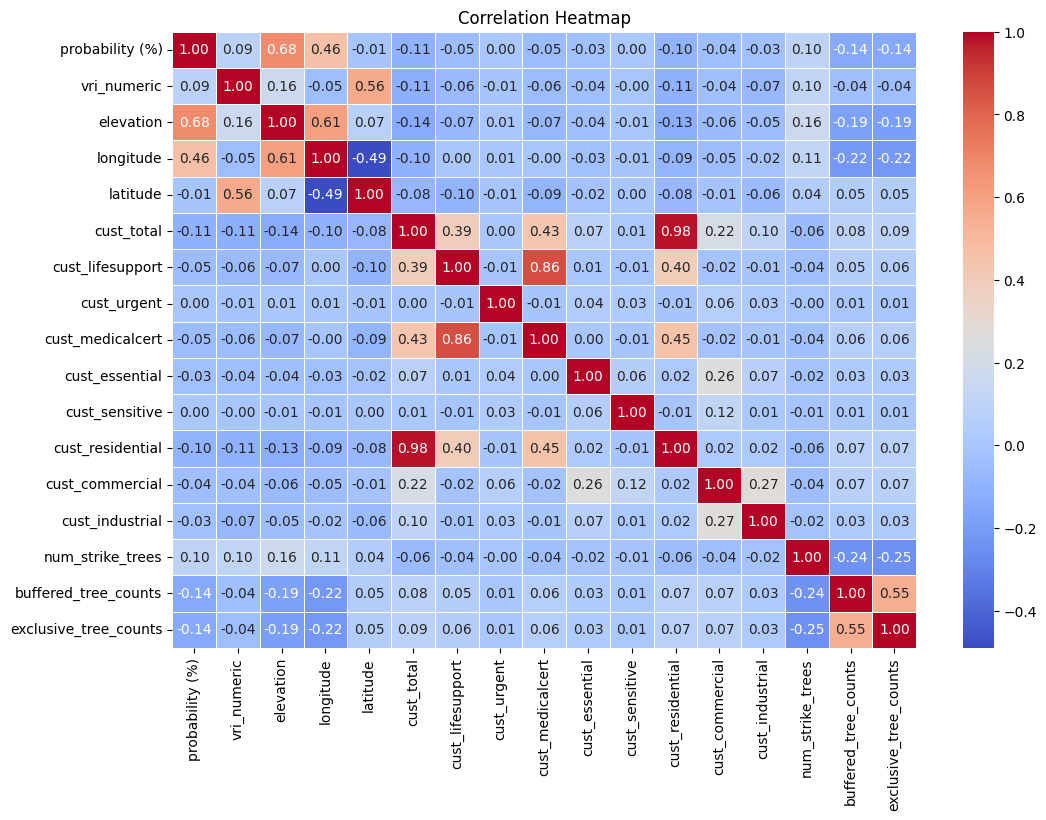

In [19]:
plt.figure(figsize=(12, 8))
correlation_matrix = df_filtered.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

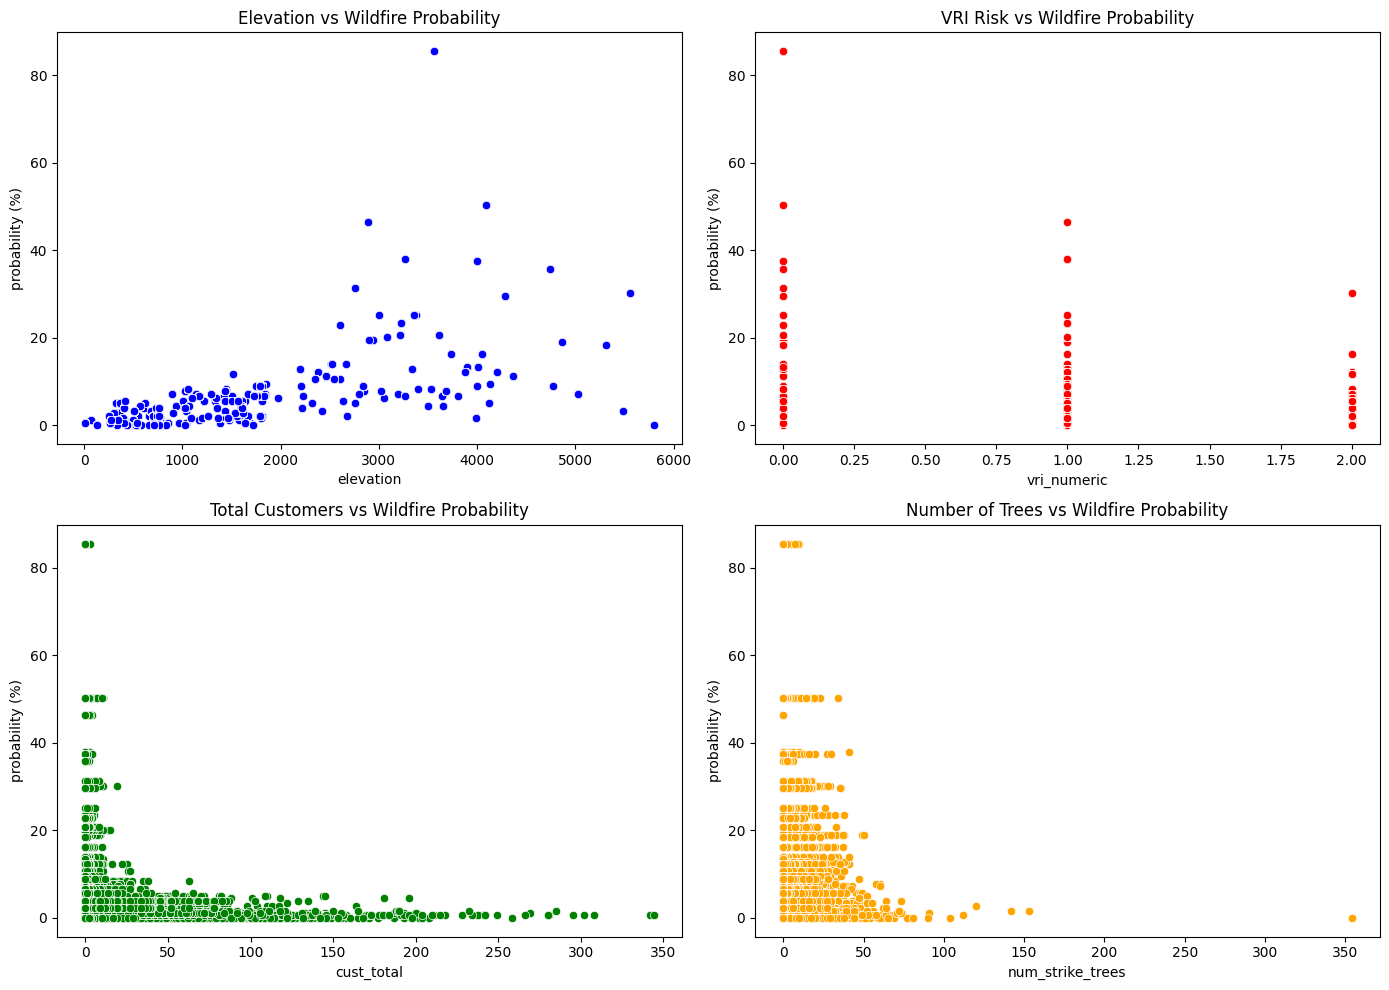

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.scatterplot(data=df_filtered, x='elevation', y='probability (%)', ax=axes[0, 0], color='blue')
axes[0, 0].set_title("Elevation vs Wildfire Probability")

sns.scatterplot(data=df_filtered, x='vri_numeric', y='probability (%)', ax=axes[0, 1], color='red')
axes[0, 1].set_title("VRI Risk vs Wildfire Probability")

sns.scatterplot(data=df_filtered, x='cust_total', y='probability (%)', ax=axes[1, 0], color='green')
axes[1, 0].set_title("Total Customers vs Wildfire Probability")

sns.scatterplot(data=df_filtered, x='num_strike_trees', y='probability (%)', ax=axes[1, 1], color='orange')
axes[1, 1].set_title("Number of Trees vs Wildfire Probability")

plt.tight_layout()
plt.show()

## 3. ML models

In [21]:
columns_to_impute = ['num_strike_trees', 'buffered_tree_counts', 'exclusive_tree_counts']
for col in columns_to_impute:
    min_val, max_val = df_filtered[col].min(), df_filtered[col].max()
    df_filtered[col] = df_filtered[col].apply(
        lambda x: np.random.randint(min_val, max_val + 1) if pd.isna(x) else x
    )

X = df_filtered.drop(columns=['probability (%)'])
y = df_filtered['probability (%)']

imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    # "Support Vector Regressor": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    # "MLP Regressor": MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=300, random_state=42)
}

results = []
for name, model in models.items():
    if name in ["Random Forest", "Linear Regression"]:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "MAE": mae, "MSE": mse, "R² Score": r2})

results_df = pd.DataFrame(results)
results_df

,Model,MAE,MSE,R² Score
0,Linear Regression,1.780110,12.674249,0.463090
1,Random Forest,0.083454,0.164754,0.993021
